In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'hayder17/breast-cancer-detection'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/hayder17/breast-cancer-detection
License(s): DbCL-1.0
  0% 0.00/87.2M [00:00<?, ?B/s]
100% 87.2M/87.2M [00:00<00:00, 1.37GB/s]


In [10]:
!unzip breast-cancer-detection.zip

Archive:  breast-cancer-detection.zip
  inflating: test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg  
  inflating: test/0/1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg  
  inflating: test/0/1588_274144628_png.rf.58cbfa689d58bca33eb53a98e2a44cb1.jpg  
  inflating: test/0/1601_364263039_png.rf.8a3b35c9dad8729063a9d9ab60fe3c1a.jpg  
  inflating: test/0/1601_751935569_png.rf.6f6ec0c9f80d50a36684d99c4bee20d0.jpg  
  inflating: test/0/1607_1416980837_png.rf.8552d91ecac36ed533f1a2a53ca77740.jpg  
  inflating: test/0/1638_1923297632_png.rf.ac117130fda038f0ce846f93eb001779.jpg  
  inflating: test/0/1649_1117924917_png.rf.8256b936a9d187da0807adc99545ee08.jpg  
  inflating: test/0/1649_428595380_png.rf.67c04778f1beca13be9fc29331df8b40.jpg  
  inflating: test/0/1657_2120850106_png.rf.2436bb2abb4f49855f5d507e3b638975.jpg  
  inflating: test/0/1688_550590619_png.rf.a04a2c456c261683e4e485eaac805f26.jpg  
  inflating: test/0/1701_2097469936_png.rf.1fa2b27ddefb835a10f416d

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Pastikan plot matplotlib ditampilkan inline di Jupyter Notebook
%matplotlib inline

# Menonaktifkan beberapa peringatan TensorFlow yang kurang relevan
tf.get_logger().setLevel('ERROR')

print("INFO: Pustaka berhasil diimpor.")

INFO: Pustaka berhasil diimpor.


In [16]:
# -- Parameter Konfigurasi --
IMG_WIDTH, IMG_HEIGHT = 128, 128  # Ukuran gambar yang akan digunakan
BATCH_SIZE = 32                    # Jumlah sampel per batch
EPOCHS = 50                        # Jumlah epoch maksimal untuk pelatihan
VAL_SPLIT = 0.2                    # Persentase data untuk validasi
PATIENCE = 10                      # Jumlah epoch tanpa peningkatan sebelum early stopping

print(f"INFO: Parameter Konfigurasi: IMG_SIZE=({IMG_WIDTH},{IMG_HEIGHT}), BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")

INFO: Parameter Konfigurasi: IMG_SIZE=(128,128), BATCH_SIZE=32, EPOCHS=50


In [17]:


# -- 1. Pengunduhan dan Pemuatan Dataset --
# The previous steps (kaggle download and unzip) should have already been run
# and the data should be available in the current directory.
DATA_DIR = './' # Assuming the zip was unzipped in the current directory

# Use tensorflow's image_dataset_from_directory to load the data
# It expects a directory structure like DATA_DIR/train/class_0/... DATA_DIR/train/class_1/... etc.

print(f"INFO: Loading dataset from local directory: {DATA_DIR}")

try:
    # Assuming the unzipped data has 'train' and 'test' directories at the root
    train_data_dir = os.path.join(DATA_DIR, 'train')
    test_data_dir = os.path.join(DATA_DIR, 'test')

    if not os.path.exists(train_data_dir):
        raise FileNotFoundError(f"Training data directory not found at {train_data_dir}")
    if not os.path.exists(test_data_dir):
         # The test directory might not exist depending on the dataset structure,
         # handle this based on your actual unzipped files.
         # For this dataset, it seems there are 'train' and 'test' directories.
         # If 'test' doesn't exist, you might need to split 'train' further.
         print(f"WARNING: Test data directory not found at {test_data_dir}. Proceeding with train only.")
         test_data_dir = None # Set to None if not available


    # Load training data, splitting off a validation set
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='binary', # Assuming binary classification (0 or 1)
        image_size=(IMG_WIDTH, IMG_HEIGHT),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42, # for reproducibility
        validation_split=VAL_SPLIT,
        subset='both' # Get both training and validation subsets
    )

    test_ds = None
    if test_data_dir and os.path.exists(test_data_dir):
        # Load test data
        test_ds = tf.keras.utils.image_dataset_from_directory(
            test_data_dir,
            labels='inferred',
            label_mode='binary', # Assuming binary classification (0 or 1)
            image_size=(IMG_WIDTH, IMG_HEIGHT),
            interpolation='nearest',
            batch_size=BATCH_SIZE,
            shuffle=False, # No need to shuffle test data
            seed=42 # for reproducibility
        )

    print("INFO: Dataset berhasil dimuat menggunakan tf.keras.utils.image_dataset_from_directory.")
    print(f"INFO: Jumlah sampel pelatihan: {len(train_ds) * BATCH_SIZE}")
    print(f"INFO: Jumlah sampel validasi: {len(val_ds) * BATCH_SIZE}")
    if test_ds:
        print(f"INFO: Jumlah sampel pengujian: {len(test_ds) * BATCH_SIZE}")
    print(f"INFO: Nama kelas: {train_ds.class_names}")

except FileNotFoundError as fnf_error:
    print(f"ERROR: Direktori data tidak ditemukan. Pastikan Anda telah mengunduh dan mengekstrak dataset dengan benar. Detail: {fnf_error}")
    raise # Rethrow the error to stop execution

except Exception as e:
    print(f"ERROR: Gagal memuat dataset dari direktori lokal. Detail: {e}")
    # Hentikan eksekusi jika dataset gagal dimuat
    raise

INFO: Loading dataset from local directory: ./
Found 2372 files belonging to 2 classes.
Using 1898 files for training.
Using 474 files for validation.
Found 336 files belonging to 2 classes.
INFO: Dataset berhasil dimuat menggunakan tf.keras.utils.image_dataset_from_directory.
INFO: Jumlah sampel pelatihan: 1920
INFO: Jumlah sampel validasi: 480
INFO: Jumlah sampel pengujian: 352
INFO: Nama kelas: ['0', '1']


In [19]:
# -- 2. Pra-pemrosesan Data --
print("\nINFO: Memulai pra-pemrosesan data...")

# Ekstrak gambar dan label dari tf.data.Dataset objects
images = []
labels = []

# Iterate over the train_ds dataset to extract images and labels
# The elements of tf.data.Dataset loaded with image_dataset_from_directory are tuples (image, label)
print("INFO: Extracting data from train_ds...")
for image_batch, label_batch in train_ds:
    # image_batch is a tensor of shape (batch_size, height, width, channels)
    # label_batch is a tensor of shape (batch_size,)
    for img_tensor, label_tensor in zip(image_batch, label_batch):
        images.append(img_tensor.numpy()) # Convert tensor to numpy array
        labels.append(int(label_tensor.numpy())) # Convert tensor to numpy array and then to int

# Do the same for val_ds to get the full dataset before splitting
print("INFO: Extracting data from val_ds...")
for image_batch, label_batch in val_ds:
    for img_tensor, label_tensor in zip(image_batch, label_batch):
        images.append(img_tensor.numpy())
        labels.append(int(label_tensor.numpy()))

if not images:
    print("ERROR: Tidak ada gambar yang berhasil diproses dari tf.data.Dataset. Harap periksa pemuatan dataset.")
    # Hentikan eksekusi jika tidak ada gambar
    raise ValueError("Tidak ada gambar yang diproses.")

images = np.array(images)
labels = np.array(labels)

# Note: Normalization to [0, 1] range is often done *before* augmentation and splitting.
# tf.keras.utils.image_dataset_from_directory returns images as type float32 in range [0, 255].
# We need to normalize them to [0, 1] or [-1, 1] depending on the model's input requirements.
# Normalizing to [0, 1] is standard for ImageDataGenerator.
print("INFO: Normalizing image pixel values to [0, 1]...")
images = images / 255.0

# Cek jumlah kelas dan distribusi label
num_classes = len(np.unique(labels))
print(f"INFO: Jumlah gambar yang diproses: {len(images)}")
print(f"INFO: Jumlah label yang diproses: {len(labels)}")
print(f"INFO: Bentuk array gambar: {images.shape}")
print(f"INFO: Bentuk array label: {labels.shape}")
print(f"INFO: Jumlah kelas: {num_classes}")
print(f"INFO: Label unik: {np.unique(labels)}")
print(f"INFO: Distribusi label: {dict(zip(*np.unique(labels, return_counts=True)))}")

if num_classes < 2:
    print("ERROR: Dataset harus memiliki setidaknya 2 kelas untuk klasifikasi.")
    raise ValueError("Dataset tidak memiliki cukup kelas.")

# Membagi data menjadi data pelatihan dan data validasi
# We need to split the combined data again because image_dataset_from_directory's split
# might not be exactly the desired ratio and the manual extraction step recombines them.
# Alternatively, you could process train_ds and val_ds separately, but splitting after
# combining ensures the desired VAL_SPLIT ratio on the full available data.
print(f"INFO: Splitting data into training and validation sets with validation_split={VAL_SPLIT}...")
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=VAL_SPLIT, random_state=42, stratify=labels
)

print(f"INFO: Jumlah data pelatihan setelah split: {len(X_train)}")
print(f"INFO: Jumlah data validasi setelah split: {len(X_val)}")

# Augmentasi Data
print("INFO: Setting up data augmentation...")
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator() # Only for ensuring consistency, normalization done earlier

# Fit the generators on the data
print("INFO: Fitting data generators...")
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

print("INFO: Pra-pemrosesan data selesai.")


INFO: Memulai pra-pemrosesan data...
INFO: Extracting data from train_ds...


<ipython-input-19-3a1a9838360b>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(label_tensor.numpy())) # Convert tensor to numpy array and then to int


INFO: Extracting data from val_ds...


<ipython-input-19-3a1a9838360b>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(label_tensor.numpy()))


INFO: Normalizing image pixel values to [0, 1]...
INFO: Jumlah gambar yang diproses: 2372
INFO: Jumlah label yang diproses: 2372
INFO: Bentuk array gambar: (2372, 128, 128, 3)
INFO: Bentuk array label: (2372,)
INFO: Jumlah kelas: 2
INFO: Label unik: [0 1]
INFO: Distribusi label: {np.int64(0): np.int64(1569), np.int64(1): np.int64(803)}
INFO: Splitting data into training and validation sets with validation_split=0.2...
INFO: Jumlah data pelatihan setelah split: 1897
INFO: Jumlah data validasi setelah split: 475
INFO: Setting up data augmentation...
INFO: Fitting data generators...
INFO: Pra-pemrosesan data selesai.


In [20]:
# -- 3. Pembuatan Model CNN --
print("\nINFO: Membangun model CNN...")

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Lapisan tambahan
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Lapisan Output: 1 unit dengan 'sigmoid' untuk klasifikasi biner (0 atau 1)
    Dense(1, activation='sigmoid')
])

# Kompilasi Model
# Untuk klasifikasi biner dengan output sigmoid, gunakan 'binary_crossentropy'
loss_function = 'binary_crossentropy'
optimizer = Adam(learning_rate=0.0001) # Learning rate bisa disesuaikan

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

model.summary()


INFO: Membangun model CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,782,017 (33.50 MB)

 Trainable params: 8,780,033 (33.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [21]:
# -- 4. Pelatihan Model --
print("\nINFO: Memulai pelatihan model...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE // 2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE), # Pastikan steps_per_epoch minimal 1
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, len(X_val) // BATCH_SIZE), # Pastikan validation_steps minimal 1
    callbacks=[early_stopping, reduce_lr]
)

print("INFO: Pelatihan model selesai.")


INFO: Memulai pelatihan model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - accuracy: 0.5015 - loss: 1.1930 - val_accuracy: 0.6562 - val_loss: 0.7297 - learning_rate: 1.0000e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.8854 - val_accuracy: 0.6540 - val_loss: 0.7358 - learning_rate: 1.0000e-04
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5492 - loss: 0.9207 - val_accuracy: 0.6652 - val_loss: 0.7905 - learning_rate: 1.0000e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3750 - loss: 1.4167 - val_accuracy: 0.6741 - val_loss: 0.7761 - learning_rate: 1.0000e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.5650 - loss: 0.9245 - val_accuracy: 0.6540 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 6/50
 1/59 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6250 - loss: 1.0370
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 1.0370 - val_accuracy: 0.6652 - val_loss: 0.8421 - learning_rate: 1.0000e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.5813 - loss: 0.8244 - val_accuracy: 0.6585 - val_loss: 0.7899 - learning_rate: 2.0000e-05
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.65


INFO: Mengevaluasi model...

Loss Validasi Akhir: 0.6671
Akurasi Validasi Akhir: 60.42%


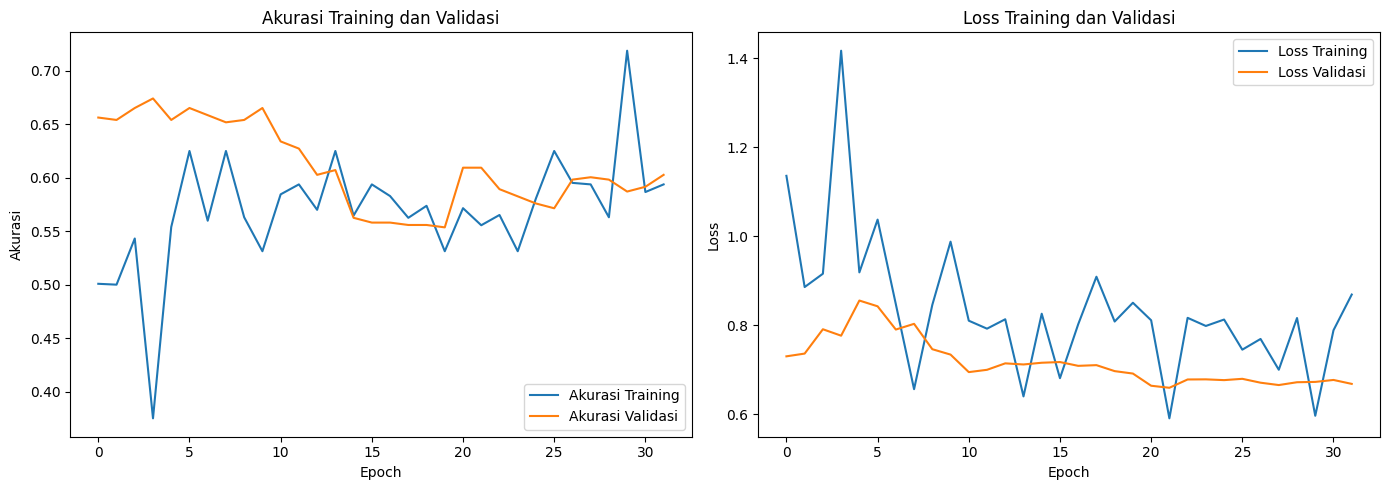

In [22]:
# -- 5. Evaluasi Model --
print("\nINFO: Mengevaluasi model...")

# Evaluasi pada data validasi penuh
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nLoss Validasi Akhir: {val_loss:.4f}")
print(f"Akurasi Validasi Akhir: {val_accuracy*100:.2f}%")

# Plotting hasil pelatihan (Akurasi dan Loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss_hist = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss_hist, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [50]:
# -- 7. Prediksi pada Gambar Baru (Contoh) --

# Definisikan nama kelas sesuai dengan dataset Anda
# Untuk dataset ini, label 0 biasanya 'benign' (jinak) dan 1 'malignant' (ganas)
# Anda bisa memverifikasi ini dari train_ds.class_names

class_names = {
    0: 'Tidak Kanker',
    1: 'Kanker (Ganas)'
}
print(f"INFO: Nama kelas yang akan digunakan untuk inferensi: {class_names}")

# Path ke model yang disimpan (ganti dengan path Anda jika berbeda)
# model_path = "saved_models/breast_cancer_classifier_model.keras"
# model_path = "breast_cancer_classifier_model.keras" # Jika disimpan di root direktori notebook

# Cek apakah variabel 'model' sudah ada (dari pelatihan sebelumnya di sesi yang sama)
try:
    model # Cek apakah model sudah terdefinisi
    print("INFO: Model sudah ada di memori dari sesi pelatihan saat ini.")
except NameError:
    print(f"INFO: Model belum ada di memori. Mencoba memuat dari file...")
    model_path = "breast_cancer_classifier_model.keras" # <--- SESUAIKAN PATH INI JIKA PERLU
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        print(f"INFO: Model berhasil dimuat dari {model_path}")
        # model.summary() # Opsional: tampilkan summary untuk verifikasi
    else:
        print(f"ERROR: File model tidak ditemukan di {model_path}. Pastikan path sudah benar atau latih model terlebih dahulu.")
        # Anda bisa menghentikan eksekusi di sini jika model tidak bisa dimuat
        # raise FileNotFoundError(f"Model tidak ditemukan di {model_path}")

def predict_single_image_kanker(image_path, model_loaded, img_width, img_height, class_names_map):
    try:
        img = Image.open(image_path).convert('RGB') # Pastikan konversi ke RGB
        img_original_size = img.size

        # Pra-pemrosesan gambar
        img_resized = img.resize((img_width, img_height))
        img_array = np.array(img_resized) / 255.0  # Normalisasi
        img_batch = np.expand_dims(img_array, axis=0) # Tambah dimensi batch

        # Lakukan prediksi
        # Output model sigmoid adalah probabilitas untuk kelas positif (kelas 1)
        prediction_prob_kanker = model_loaded.predict(img_batch)[0][0]

        # Tentukan kelas berdasarkan ambang batas 0.5
        if prediction_prob_kanker > 0.5:
            predicted_class_index = 1 # Kanker (Ganas)
            confidence = prediction_prob_kanker
        else:
            predicted_class_index = 0 # Tidak Kanker (Jinak)
            confidence = 1 - prediction_prob_kanker

        # Dapatkan label nama kelas yang diprediksi
        predicted_label = class_names_map.get(predicted_class_index, "Label Tidak Diketahui")

        # Tampilkan hasil
        print(f"\n--- Hasil Prediksi untuk gambar: {os.path.basename(image_path)} ---")
        print(f"Probabilitas(untuk kelas 'Kanker'): {prediction_prob_kanker:.4f}")
        print(f"Prediksi Label: {predicted_label}")
        print(f"Akurasi Prediksi (Keyakinan): {confidence*100:.2f}%")

        # Tampilkan gambar dengan prediksinya
        plt.figure(figsize=(6,6))
        # plt.imshow(img_resized) # Jika ingin menampilkan gambar yang diresize
        plt.imshow(img) # Tampilkan gambar asli untuk kejelasan
        plt.title(f"Prediksi: {predicted_label}\nAkurasi Prediksi: {confidence*100:.2f}%", fontsize=10)
        plt.axis('off')
        plt.show()

        return predicted_label, confidence

    except FileNotFoundError:
        print(f"ERROR: File gambar tidak ditemukan di {image_path}")
        return None, None
    except Exception as e:
        print(f"ERROR: Terjadi kesalahan saat memproses gambar {image_path}: {e}")
        return None, None

print("INFO: Fungsi predict_single_image_kanker siap digunakan.")

INFO: Nama kelas yang akan digunakan untuk inferensi: {0: 'Tidak Kanker', 1: 'Kanker (Ganas)'}
INFO: Model sudah ada di memori dari sesi pelatihan saat ini.
INFO: Fungsi predict_single_image_kanker siap digunakan.


Screenshot 2025-05-30 031908.png


INFO: Menjalankan inferensi untuk 1 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

--- Hasil Prediksi untuk gambar: Screenshot 2025-05-30 031908.png ---
Probabilitas(untuk kelas 'Kanker'): 0.3353
Prediksi Label: Tidak Kanker
Akurasi Prediksi (Keyakinan): 66.47%


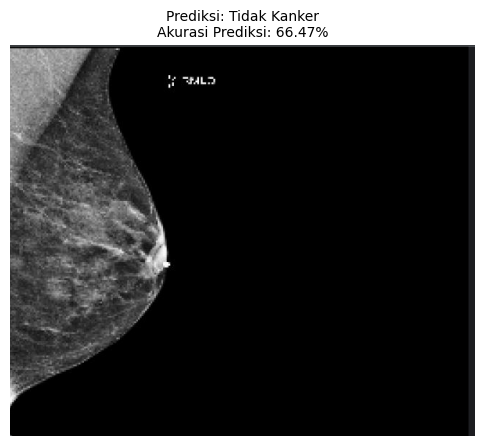

Ringkasan untuk Screenshot 2025-05-30 031908.png: Label = Tidak Kanker, Keyakinan = 66.47%


In [51]:
# -- Contoh Penggunaan Inferensi --

# Pastikan model sudah ada di memori (baik dari pelatihan atau sudah dimuat)
if 'model' not in locals() and 'model' not in globals():
    print("ERROR: Variabel 'model' tidak terdefinisi. Latih atau muat model terlebih dahulu.")
else:
    # GANTI DENGAN PATH KE GAMBAR YANG INGIN ANDA UJI
    # Unggah gambar ke direktori kerja Jupyter Notebook Anda atau berikan path lengkapnya.
    # Contoh:
    path_gambar_uji_1 = "nama_file_gambar_anda_1.jpg"  # <--- GANTI INI
    path_gambar_uji_2 = "Screenshot 2025-05-30 031908.png"  # <--- GANTI INI

    daftar_gambar_untuk_diuji = []

    if os.path.exists(path_gambar_uji_1):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_1)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_1}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    if os.path.exists(path_gambar_uji_2):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_2)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_2}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    # Tambahkan path gambar lain jika perlu
    # daftar_gambar_untuk_diuji.append("path/lain/ke/gambar.jpeg")

    if not daftar_gambar_untuk_diuji:
        print("\nINFO: Tidak ada gambar uji yang valid ditemukan.")
        print("Silakan unggah gambar ke direktori notebook Anda dan perbarui variabel 'path_gambar_uji_...' di atas,")
        print("kemudian jalankan sel ini lagi.")
        print("Contoh: Jika Anda mengunggah 'breast_image.png', maka tulis: path_gambar_uji_1 = 'breast_image.png'")
    else:
        print(f"\nINFO: Menjalankan inferensi untuk {len(daftar_gambar_untuk_diuji)} gambar...")
        for img_path in daftar_gambar_untuk_diuji:
            # Menggunakan fungsi yang telah disesuaikan
            label_prediksi, skor_keyakinan = predict_single_image_kanker(
                img_path,
                model,
                IMG_WIDTH,
                IMG_HEIGHT,
                class_names
            )
            # Anda bisa melakukan sesuatu dengan hasilnya di sini jika perlu
            if label_prediksi is not None:
                print(f"Ringkasan untuk {os.path.basename(img_path)}: Label = {label_prediksi}, Keyakinan = {skor_keyakinan*100:.2f}%")


INFO: Menjalankan inferensi untuk 1 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

--- Hasil Prediksi untuk gambar: ganas.png ---
Probabilitas(untuk kelas 'Kanker'): 0.5044
Prediksi Label: Kanker (Ganas)
Akurasi Prediksi (Keyakinan): 50.44%


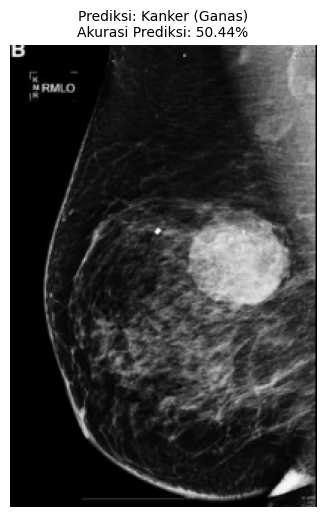

Ringkasan untuk ganas.png: Label = Kanker (Ganas), Keyakinan = 50.44%


In [52]:

# Pastikan model sudah ada di memori (baik dari pelatihan atau sudah dimuat)
if 'model' not in locals() and 'model' not in globals():
    print("ERROR: Variabel 'model' tidak terdefinisi. Latih atau muat model terlebih dahulu.")
else:
    # GANTI DENGAN PATH KE GAMBAR YANG INGIN ANDA UJI
    # Unggah gambar ke direktori kerja Jupyter Notebook Anda atau berikan path lengkapnya.
    # Contoh:
    path_gambar_uji_1 = "105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg"  # <--- GANTI INI
    path_gambar_uji_2 = "ganas.png"  # <--- GANTI INI

    daftar_gambar_untuk_diuji = []

    if os.path.exists(path_gambar_uji_1):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_1)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_1}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    if os.path.exists(path_gambar_uji_2):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_2)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_2}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    # Tambahkan path gambar lain jika perlu
    # daftar_gambar_untuk_diuji.append("path/lain/ke/gambar.jpeg")

    if not daftar_gambar_untuk_diuji:
        print("\nINFO: Tidak ada gambar uji yang valid ditemukan.")
        print("Silakan unggah gambar ke direktori notebook Anda dan perbarui variabel 'path_gambar_uji_...' di atas,")
        print("kemudian jalankan sel ini lagi.")
        print("Contoh: Jika Anda mengunggah 'breast_image.png', maka tulis: path_gambar_uji_1 = 'breast_image.png'")
    else:
        print(f"\nINFO: Menjalankan inferensi untuk {len(daftar_gambar_untuk_diuji)} gambar...")
        for img_path in daftar_gambar_untuk_diuji:
            # Menggunakan fungsi yang telah disesuaikan
            label_prediksi, skor_keyakinan = predict_single_image_kanker(
                img_path,
                model,
                IMG_WIDTH,
                IMG_HEIGHT,
                class_names
            )
            # Anda bisa melakukan sesuatu dengan hasilnya di sini jika perlu
            if label_prediksi is not None:
                print(f"Ringkasan untuk {os.path.basename(img_path)}: Label = {label_prediksi}, Keyakinan = {skor_keyakinan*100:.2f}%")


INFO: Menjalankan inferensi untuk 1 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Hasil Prediksi untuk gambar: 105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg ---
Probabilitas(untuk kelas 'Kanker'): 0.2830
Prediksi Label: Tidak Kanker
Akurasi Prediksi (Keyakinan): 71.70%


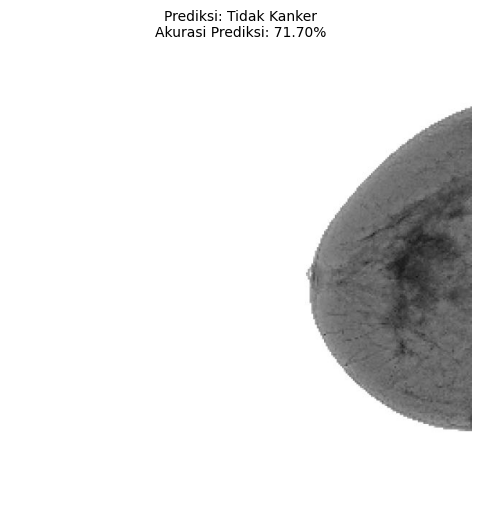

Ringkasan untuk 105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg: Label = Tidak Kanker, Keyakinan = 71.70%


In [53]:
# Pastikan model sudah ada di memori (baik dari pelatihan atau sudah dimuat)
if 'model' not in locals() and 'model' not in globals():
    print("ERROR: Variabel 'model' tidak terdefinisi. Latih atau muat model terlebih dahulu.")
else:
    # GANTI DENGAN PATH KE GAMBAR YANG INGIN ANDA UJI
    # Unggah gambar ke direktori kerja Jupyter Notebook Anda atau berikan path lengkapnya.
    # Contoh:
    path_gambar_uji_1 = "test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg"  # <--- GANTI INI
    path_gambar_uji_2 = "contoh.png"  # <--- GANTI INI

    daftar_gambar_untuk_diuji = []

    if os.path.exists(path_gambar_uji_1):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_1)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_1}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    if os.path.exists(path_gambar_uji_2):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_2)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_2}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    # Tambahkan path gambar lain jika perlu
    # daftar_gambar_untuk_diuji.append("path/lain/ke/gambar.jpeg")

    if not daftar_gambar_untuk_diuji:
        print("\nINFO: Tidak ada gambar uji yang valid ditemukan.")
        print("Silakan unggah gambar ke direktori notebook Anda dan perbarui variabel 'path_gambar_uji_...' di atas,")
        print("kemudian jalankan sel ini lagi.")
        print("Contoh: Jika Anda mengunggah 'breast_image.png', maka tulis: path_gambar_uji_1 = 'breast_image.png'")
    else:
        print(f"\nINFO: Menjalankan inferensi untuk {len(daftar_gambar_untuk_diuji)} gambar...")
        for img_path in daftar_gambar_untuk_diuji:
            # Menggunakan fungsi yang telah disesuaikan
            label_prediksi, skor_keyakinan = predict_single_image_kanker(
                img_path,
                model,
                IMG_WIDTH,
                IMG_HEIGHT,
                class_names
            )
            # Anda bisa melakukan sesuatu dengan hasilnya di sini jika perlu
            if label_prediksi is not None:
                print(f"Ringkasan untuk {os.path.basename(img_path)}: Label = {label_prediksi}, Keyakinan = {skor_keyakinan*100:.2f}%")

1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg


INFO: Menjalankan inferensi untuk 1 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Hasil Prediksi untuk gambar: 2028_2082854771_png.rf.c48712e6c2dda9a2315a0dfb713adfee.jpg ---
Probabilitas(untuk kelas 'Kanker'): 0.2486
Prediksi Label: Tidak Kanker
Akurasi Prediksi (Keyakinan): 75.14%


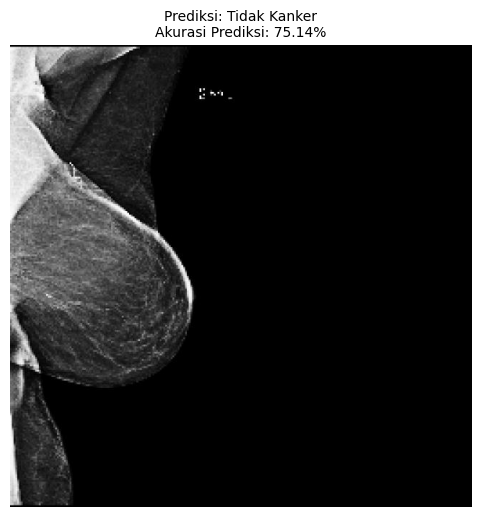

Ringkasan untuk 2028_2082854771_png.rf.c48712e6c2dda9a2315a0dfb713adfee.jpg: Label = Tidak Kanker, Keyakinan = 75.14%


In [54]:
# Pastikan model sudah ada di memori (baik dari pelatihan atau sudah dimuat)
if 'model' not in locals() and 'model' not in globals():
    print("ERROR: Variabel 'model' tidak terdefinisi. Latih atau muat model terlebih dahulu.")
else:
    # GANTI DENGAN PATH KE GAMBAR YANG INGIN ANDA UJI
    # Unggah gambar ke direktori kerja Jupyter Notebook Anda atau berikan path lengkapnya.
    # Contoh:
    path_gambar_uji_1 = "test/0/2028_2082854771_png.rf.c48712e6c2dda9a2315a0dfb713adfee.jpg"  # <--- GANTI INI
    path_gambar_uji_2 = "contoh.png"  # <--- GANTI INI

    daftar_gambar_untuk_diuji = []

    if os.path.exists(path_gambar_uji_1):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_1)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_1}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    if os.path.exists(path_gambar_uji_2):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_2)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_2}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    # Tambahkan path gambar lain jika perlu
    # daftar_gambar_untuk_diuji.append("path/lain/ke/gambar.jpeg")

    if not daftar_gambar_untuk_diuji:
        print("\nINFO: Tidak ada gambar uji yang valid ditemukan.")
        print("Silakan unggah gambar ke direktori notebook Anda dan perbarui variabel 'path_gambar_uji_...' di atas,")
        print("kemudian jalankan sel ini lagi.")
        print("Contoh: Jika Anda mengunggah 'breast_image.png', maka tulis: path_gambar_uji_1 = 'breast_image.png'")
    else:
        print(f"\nINFO: Menjalankan inferensi untuk {len(daftar_gambar_untuk_diuji)} gambar...")
        for img_path in daftar_gambar_untuk_diuji:
            # Menggunakan fungsi yang telah disesuaikan
            label_prediksi, skor_keyakinan = predict_single_image_kanker(
                img_path,
                model,
                IMG_WIDTH,
                IMG_HEIGHT,
                class_names
            )
            # Anda bisa melakukan sesuatu dengan hasilnya di sini jika perlu
            if label_prediksi is not None:
                print(f"Ringkasan untuk {os.path.basename(img_path)}: Label = {label_prediksi}, Keyakinan = {skor_keyakinan*100:.2f}%")

1025_773597682_png.rf.10eef608772845290c0ed1c5dc80c3ac.jpg


INFO: Menjalankan inferensi untuk 1 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Hasil Prediksi untuk gambar: 16703_87510051_png.rf.c4b59cce87ffe7abb2db9fa1ac5d8431.jpg ---
Probabilitas(untuk kelas 'Kanker'): 0.8392
Prediksi Label: Kanker (Ganas)
Akurasi Prediksi (Keyakinan): 83.92%


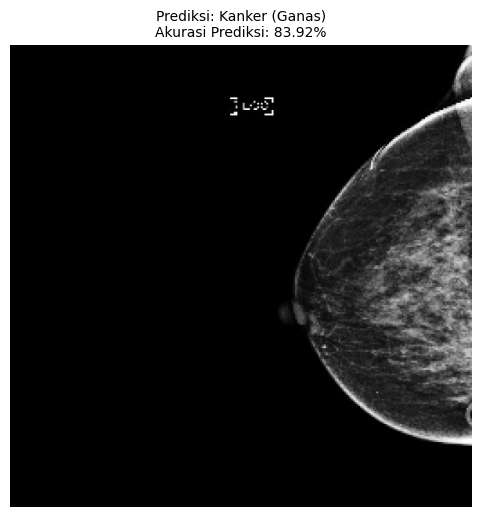

Ringkasan untuk 16703_87510051_png.rf.c4b59cce87ffe7abb2db9fa1ac5d8431.jpg: Label = Kanker (Ganas), Keyakinan = 83.92%


In [55]:
# Pastikan model sudah ada di memori (baik dari pelatihan atau sudah dimuat)
if 'model' not in locals() and 'model' not in globals():
    print("ERROR: Variabel 'model' tidak terdefinisi. Latih atau muat model terlebih dahulu.")
else:
    # GANTI DENGAN PATH KE GAMBAR YANG INGIN ANDA UJI
    # Unggah gambar ke direktori kerja Jupyter Notebook Anda atau berikan path lengkapnya.
    # Contoh:
    path_gambar_uji_1 = "test/1/16703_87510051_png.rf.c4b59cce87ffe7abb2db9fa1ac5d8431.jpg"  # <--- GANTI INI
    path_gambar_uji_2 = "contoh.png"  # <--- GANTI INI

    daftar_gambar_untuk_diuji = []

    if os.path.exists(path_gambar_uji_1):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_1)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_1}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    if os.path.exists(path_gambar_uji_2):
        daftar_gambar_untuk_diuji.append(path_gambar_uji_2)
    else:
        print(f"WARNING: Gambar uji '{path_gambar_uji_2}' tidak ditemukan. Silakan unggah atau perbaiki path.")

    # Tambahkan path gambar lain jika perlu
    # daftar_gambar_untuk_diuji.append("path/lain/ke/gambar.jpeg")

    if not daftar_gambar_untuk_diuji:
        print("\nINFO: Tidak ada gambar uji yang valid ditemukan.")
        print("Silakan unggah gambar ke direktori notebook Anda dan perbarui variabel 'path_gambar_uji_...' di atas,")
        print("kemudian jalankan sel ini lagi.")
        print("Contoh: Jika Anda mengunggah 'breast_image.png', maka tulis: path_gambar_uji_1 = 'breast_image.png'")
    else:
        print(f"\nINFO: Menjalankan inferensi untuk {len(daftar_gambar_untuk_diuji)} gambar...")
        for img_path in daftar_gambar_untuk_diuji:
            # Menggunakan fungsi yang telah disesuaikan
            label_prediksi, skor_keyakinan = predict_single_image_kanker(
                img_path,
                model,
                IMG_WIDTH,
                IMG_HEIGHT,
                class_names
            )
            # Anda bisa melakukan sesuatu dengan hasilnya di sini jika perlu
            if label_prediksi is not None:
                print(f"Ringkasan untuk {os.path.basename(img_path)}: Label = {label_prediksi}, Keyakinan = {skor_keyakinan*100:.2f}%")